# Bank Heist Project Submission

**Description**

Given a list of bank, their locations, the amount of money each bank holds, and the amount of time it would take to rob each bank; apply your knowledge of algorithms to make as much profit as possible!

**Design a solution that finds a list of banks that when robbed will maximize your profit, while following these constraints:**

- Total time for robbery cannot exceed **24 hours**. This includes travel time between banks + time it takes to rob the bank + time it takes to get to the helicopter escape zone

- Travel speed from one bank to another is **30 km/h**
    - Use the x and y coordinates to calculate the distance (in km) between banks
    - Use the distance and travel speed to calculate the amount of time it takes to get from one bank to another

- Solution must run under **3 minutes**

- You can start anywhere, but you have to end at the **helicopter escape zone** located at coordinates **(0,0)**

**Hints**

Most of the design paradigms you saw in class will work for this. Start with something that's easier (brute-force or greedy algorithm) and then work towards a better design once it works:

    - Divide-and-conquer
    - Brute Force
    - Greedy Algorithm
    - Dynamic Programming
    - Backtracking
    - Breadth-first & Depth-first search
Some we haven't covered:

    - Branch & Bound
    - Prune & Search
    
Because there are too many banks at each step, you will need to select only some candidates to explore.

If you find yourself using a nearest-neighbors type of approach, consider using a KD-Tree or a Ball Tree to speed it up.

There are good implementations of KD-Trees and nearest neighbours in scipy, sklearn and this [library](https://github.com/lmcinnes/pynndescent)

You can work your algorithm backwards (starting at the end and backing up to the starting point) or forwards (finding a starting point and looping until there is no time left). They will lead to different designs and results.

## Step 1: Imports

You can import the libraries you intend on using here or as you go along.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time as tm
from sklearn.neighbors import NearestNeighbors

from check_solution import distance, check_solution


## Step 2: Load Data

The `bank_data.csv` file is located in the **data** folder. Make sure you use the correct path.

In [2]:
df = pd.read_csv('bank_data.csv')
df

,id,x_coordinate,y_coordinate,money,time (hr)
0,0,2.851925,1.201712,29700,0.273403
1,1,4.150372,-2.654334,6500,0.064040
2,2,-1.494092,-1.230419,89400,0.127458
3,3,1.271326,-0.088520,96100,1.315029
4,4,2.471113,-0.592810,41100,0.164393
...,...,...,...,...,...
9995,9995,-2.472127,4.787304,2100,0.494904
9996,9996,1.034968,-4.321240,54900,0.492866
9997,9997,-0.512720,-2.949173,32200,0.933033
9998,9998,2.626841,-3.482923,5100,0.551312


## Step 3: Data Exploration

Explore the data set to get a general understanding of what you're working with.

Feel free to add additional cells, and remove the ones you don't use.

In [3]:
df['profitable'] = (df['money'] / df['time (hr)'])
df.sort_values(by='profitable', ascending = False, inplace=True)
df = df.reset_index(drop=True)
df

,id,x_coordinate,y_coordinate,money,time (hr),profitable
0,3613,-1.950527,-1.495858,54400,0.000186,2.929603e+08
1,9546,-1.810721,-0.795421,75100,0.000788,9.530556e+07
2,3803,3.867586,0.918332,18500,0.000358,5.169381e+07
3,6528,-0.282937,3.224334,33900,0.000769,4.407762e+07
4,9583,3.393835,-2.790830,24000,0.001131,2.121396e+07
...,...,...,...,...,...,...
9995,1838,-2.179862,-3.064824,100,1.486872,6.725528e+01
9996,8832,1.934915,-4.278272,100,1.490015,6.711343e+01
9997,4764,0.565196,1.437413,100,1.491462,6.704829e+01
9998,2123,-3.105083,-1.135305,100,1.494467,6.691347e+01


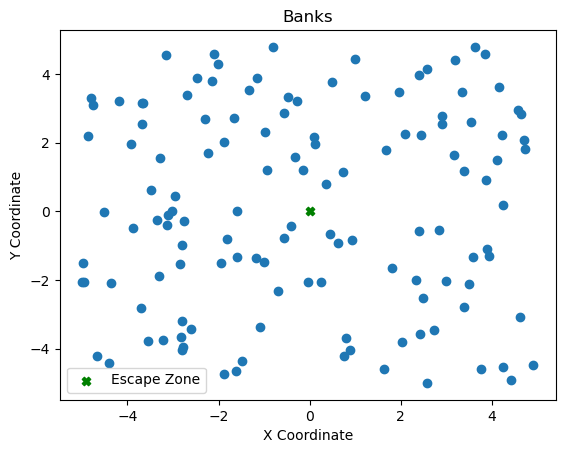

In [4]:
to_be_plot = df.head(128) #when it was verified in OPTION 1 (below) that 128 banks were rob, then I update my "head" to "128"
plt.scatter(to_be_plot['x_coordinate'], to_be_plot['y_coordinate'])

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Banks')

plt.scatter(0, 0, color='green', marker='X', label='Escape Zone')
plt.legend()

plt.show()

In [10]:
df

,id,x_coordinate,y_coordinate,money,time (hr),profitable
0,3613,-1.950527,-1.495858,54400,0.000186,2.929603e+08
1,9546,-1.810721,-0.795421,75100,0.000788,9.530556e+07
2,3803,3.867586,0.918332,18500,0.000358,5.169381e+07
3,6528,-0.282937,3.224334,33900,0.000769,4.407762e+07
4,9583,3.393835,-2.790830,24000,0.001131,2.121396e+07
...,...,...,...,...,...,...
9995,1838,-2.179862,-3.064824,100,1.486872,6.725528e+01
9996,8832,1.934915,-4.278272,100,1.490015,6.711343e+01
9997,4764,0.565196,1.437413,100,1.491462,6.704829e+01
9998,2123,-3.105083,-1.135305,100,1.494467,6.691347e+01


## Robbering banks by Profit

In [11]:
start_time = tm.time()

list_banks = []
total_stolen_amount = 0
time = 0
current_x, current_y = 0.0, 0.0

for index, row in df.iterrows():
        distance = math.sqrt((row['x_coordinate'] - current_x)**2 + (row['y_coordinate'] - current_y)**2)
        travel_time = distance / 30
        rob_time = row['time (hr)']
        if time + travel_time + rob_time <= 24:
                total_stolen_amount += row['money']
                list_banks.append(int(row['id']))
                time += rob_time + travel_time
                current_x, current_y = row['x_coordinate'], row['y_coordinate']
                print(f"--> time = {time} {row['id']} {rob_time} {travel_time}")

list_banks.reverse()


print(f'Total stolen: {total_stolen_amount:.2f} in {time:.2f} hours')
print(list_banks)

end_time = tm.time()

--> time = 0.08212161382580292 3613.0 0.0001856906781643 0.08193592314763862
--> time = 0.10671803190985622 9546.0 0.0007879918265028 0.0238084262575505
--> time = 0.3047853472332805 3803.0 0.0003578765375668 0.19770943878585745
--> time = 0.46382455583978743 6528.0 0.0007690978284647 0.15827011077804226
--> time = 0.6999520037475283 9583.0 0.0011313304321841 0.23499611747555676
--> time = 0.8529404889055698 5933.0 0.0049220478919271 0.14806643726611438
--> time = 1.0814473461599259 9195.0 0.0018311123131364 0.22667574494121964
--> time = 1.2968171597663898 4757.0 0.0015437874594811 0.21382602614698282
--> time = 1.3585691243225129 8550.0 0.0003604376574103 0.06139152689871268
--> time = 1.4442624738749468 4499.0 0.0042975494319462 0.08139580012048774
--> time = 1.7485970991324808 9241.0 0.0077745434983739 0.2965600817591602
--> time = 2.059594831122949 7343.0 0.0021629945887121 0.30883473740175604
--> time = 2.2886684062336418 3798.0 0.0043175480126298 0.22475602709806325
--> time = 2

Total stolen: 6467300.00 in 24.00 hours
[9448, 232, 5166, 279, 6216, 6535, 507, 6254, 8846, 299, 5296, 5295, 4465, 9275, 8231, 7595, 7877, 8703, 8908, 6712, 444, 9049, 5155, 2190, 2521, 4345, 517, 5725, 7583, 3089, 4794, 3297, 9880, 7689, 7649, 7764, 8375, 1733, 2442, 1372, 3026, 6759, 2243, 3516, 5562, 5126, 7087, 790, 613, 4906, 8286, 1997, 2729, 5719, 6987, 7665, 3005, 5563, 8355, 7701, 2741, 6104, 9378, 8849, 2827, 6022, 4287, 2037, 5610, 8525, 3193, 9228, 58, 209, 951, 2656, 70, 9881, 6740, 4789, 8022, 4696, 8966, 2346, 7074, 9653, 2331, 9736, 9401, 3926, 7064, 4605, 8206, 4725, 7258, 8287, 1757, 1914, 6468, 524, 433, 8469, 8690, 8579, 7560, 3466, 4987, 3914, 865, 5135, 2928, 487, 6097, 8562, 8436, 4762, 7544, 3798, 7343, 9241, 4499, 8550, 4757, 9195, 5933, 9583, 6528, 3803, 9546, 3613]


In [12]:
df.loc[(df['id'] == 9448)]

,id,x_coordinate,y_coordinate,money,time (hr),profitable
254,9448,3.847943,-3.626517,17400,0.038263,454750.210301


In [13]:
time_total = 0
prev = df.loc[(df['id'] == list_banks[0])]
for e in list_banks:
    row = df.loc[(df['id'] == e)]#changed from "iloc" to "loc" and now its verifies my last bank ID (9448)
    assert row is not None, (
        f"Used more than 24h! Time left: {t_remaining}"
    )
       
    # row = df.loc[e]
    prev_x, prev_y = prev["x_coordinate"], prev["y_coordinate"]
    distance = math.sqrt((row['x_coordinate'] - prev_x)**2 + (row['y_coordinate'] - prev_y)**2)
    time_total += row['time (hr)'] + distance / 30
    prev = row
    print(f"time = {time_total} {e} {row['id']} {row['time (hr)']} {distance / 30}")
    



time = 254    0.038263
Name: time (hr), dtype: float64 9448 254    9448
Name: id, dtype: int64 254    0.038263
Name: time (hr), dtype: float64 0.0


C:\Users\teka_\AppData\Local\Temp\ipykernel_22356\414226992.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  distance = math.sqrt((row['x_coordinate'] - prev_x)**2 + (row['y_coordinate'] - prev_y)**2)


TypeError: cannot convert the series to <class 'float'>

In [14]:
from check_solution import distance, check_solution
check_solution(list_banks, df)

time remaining -96.19773381431776


AssertionError: Used more than 24h! Time left: -96.19773381431776

In [15]:
number_of_banks = len(list_banks)
number_of_banks

130

## Step 4: Solution 

Your solution must provide:

- A list of bank IDs in order that you rob them
- Total amount you were able to rob
- Time it took to rob + escape
- The execution time for your code to run

**Important: Your solution must respect all the constraints mentioned in the description.**

Feel free to add additional cells, and remove the ones you don't use.

In [16]:
#A list of bank IDs in order that you rob them
list_banks

[9448,
 232,
 5166,
 279,
 6216,
 6535,
 507,
 6254,
 8846,
 299,
 5296,
 5295,
 4465,
 9275,
 8231,
 7595,
 7877,
 8703,
 8908,
 6712,
 444,
 9049,
 5155,
 2190,
 2521,
 4345,
 517,
 5725,
 7583,
 3089,
 4794,
 3297,
 9880,
 7689,
 7649,
 7764,
 8375,
 1733,
 2442,
 1372,
 3026,
 6759,
 2243,
 3516,
 5562,
 5126,
 7087,
 790,
 613,
 4906,
 8286,
 1997,
 2729,
 5719,
 6987,
 7665,
 3005,
 5563,
 8355,
 7701,
 2741,
 6104,
 9378,
 8849,
 2827,
 6022,
 4287,
 2037,
 5610,
 8525,
 3193,
 9228,
 58,
 209,
 951,
 2656,
 70,
 9881,
 6740,
 4789,
 8022,
 4696,
 8966,
 2346,
 7074,
 9653,
 2331,
 9736,
 9401,
 3926,
 7064,
 4605,
 8206,
 4725,
 7258,
 8287,
 1757,
 1914,
 6468,
 524,
 433,
 8469,
 8690,
 8579,
 7560,
 3466,
 4987,
 3914,
 865,
 5135,
 2928,
 487,
 6097,
 8562,
 8436,
 4762,
 7544,
 3798,
 7343,
 9241,
 4499,
 8550,
 4757,
 9195,
 5933,
 9583,
 6528,
 3803,
 9546,
 3613]

In [17]:
#Total amount you were able to rob
total_stolen_amount

6467300.0

In [18]:
#Time it took to rob + escape
time

23.996329199154303

In [19]:
#The execution time for your code to run
execution_time = end_time - start_time
execution_time

0.3546602725982666

### Briefly explain your solution/approach, and how it works.

I created a column with the most profitable ("df['profitable']") 
    
        from the index 0 (start point of the df['profitable']), the code was running. 
        By coding "time <=24", when the time to go to escape zone was added, the time was higher than 24h, thats why           the condition was "<= 23.8" that upon addition of the time to go to escape zone: 
        the total rob 6 467,300.00 in 23.99 hours 
        

## Step 5: Summary and Results

1. What is the total amount of money you were able to collect?


In [20]:
print(f'Total stolen: {total_stolen_amount:.2f} in dolars')

Total stolen: 6467300.00 in dolars


2. What are the IDs of the banks you robbed, in order? Use the list from your solution.

In [21]:
print('List of banks:', '[' + ', '.join(map(str, list_banks)) + ']')

List of banks: [9448, 232, 5166, 279, 6216, 6535, 507, 6254, 8846, 299, 5296, 5295, 4465, 9275, 8231, 7595, 7877, 8703, 8908, 6712, 444, 9049, 5155, 2190, 2521, 4345, 517, 5725, 7583, 3089, 4794, 3297, 9880, 7689, 7649, 7764, 8375, 1733, 2442, 1372, 3026, 6759, 2243, 3516, 5562, 5126, 7087, 790, 613, 4906, 8286, 1997, 2729, 5719, 6987, 7665, 3005, 5563, 8355, 7701, 2741, 6104, 9378, 8849, 2827, 6022, 4287, 2037, 5610, 8525, 3193, 9228, 58, 209, 951, 2656, 70, 9881, 6740, 4789, 8022, 4696, 8966, 2346, 7074, 9653, 2331, 9736, 9401, 3926, 7064, 4605, 8206, 4725, 7258, 8287, 1757, 1914, 6468, 524, 433, 8469, 8690, 8579, 7560, 3466, 4987, 3914, 865, 5135, 2928, 487, 6097, 8562, 8436, 4762, 7544, 3798, 7343, 9241, 4499, 8550, 4757, 9195, 5933, 9583, 6528, 3803, 9546, 3613]


3. How much time did it take to rob all the banks + escape? Does your solution meet the 24 hour constraint? 

In [22]:
print(f'The time taken to rob all the banks + escape: {time:.2f} in hours') 

The time taken to rob all the banks + escape: 24.00 in hours


4. What is the execution time of your solution? Does your solution run in 3 minutes or less?

In [23]:
execution_time = end_time - start_time
print(f'The execution time for my code to run: {execution_time:.2f} in seconds')

The execution time for my code to run: 0.35 in seconds


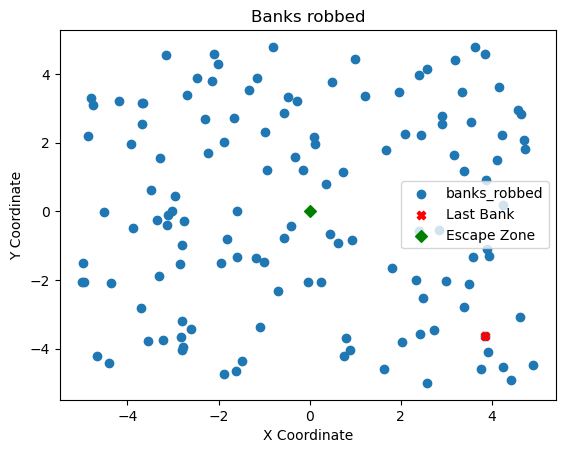

In [24]:
#Graph of all the banks robbed

banks_robbed = df[df['id'].isin(list_banks)]
plt.scatter(banks_robbed['x_coordinate'], banks_robbed['y_coordinate'], label='banks_robbed')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Banks robbed')


plt.scatter(current_x, current_y, color='red', marker='X', label='Last Bank')


plt.scatter(0.0,0.0, color='green', marker='D', label='Escape Zone')


plt.legend()


plt.show()

